In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import json
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Input, Embedding, Activation, Dense, LSTM, Conv1D, MaxPool1D
from keras.models import Sequential, Model
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# import zipfile
# zip_file_path = 'glove.6B.zip'
# extract_dir = 'path/to/extract'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall()
#     file_names = zip_ref.namelist()

# print("File unzipped successfully!")
# print("Names of the files after unzipping:", file_names)

In [ ]:
glove_vectors = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


# Define the LSTM-based model

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(LSTMTagger, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.linear(lstm_out)
        return tag_space

# Data Preprocessing

##### Load Data, Prepare Vocab and Padded Sequences.

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, data_path, glove_vectors, max_seq_length):
        self.data_path = data_path
        self.glove_vectors = glove_vectors
        self.max_seq_length = max_seq_length
        self.data = self.load_data()
        self.word_to_idx, self.label_to_idx = self.prepare_vocab()
        self.X, self.y = self.prepare_data()

    def load_data(self):
        with open(self.data_path, 'r') as f:
            data = json.load(f)
        return data

    def prepare_vocab(self):
        word_to_idx = {word: idx + 1 for idx, word in enumerate(self.glove_vectors.index_to_key)}
        label_to_idx = {"B": 0, "I": 1, "O": 2}
        return word_to_idx, label_to_idx

    def prepare_data(self):
        X, y = [], []
        for sample in self.data.values():
            text = sample['text'].split()
            labels = sample['labels']
            text_indices = [self.word_to_idx.get(word, 0) for word in text]
            X.append(torch.tensor(text_indices))
            y.append(torch.tensor([self.label_to_idx[label] for label in labels]))
        X_padded = pad_sequence(X, batch_first=True, padding_value=0)
        y_padded = pad_sequence(y, batch_first=True, padding_value=0)
        return X_padded, y_padded

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# TrainingModel Function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_all_preds = []
        train_all_labels = []
        for text, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(text)
            loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 2)
            train_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            train_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        val_loss = 0
        val_all_preds = []
        val_all_labels = []
        with torch.no_grad():
            model.eval()
            for text, labels in val_loader:
                outputs = model(text)
                loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 2)
                val_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
                val_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
        val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Macro-F1: {train_f1:.4f}, Validation Macro-F1: {val_f1:.4f}")

    return train_losses, val_losses, train_f1s, val_f1s


# Main Function

In [ ]:
max_seq_length = 100

# Create data loaders
train_dataset = ReviewDataset('ATE_train.json', glove_vectors, max_seq_length)
val_dataset = ReviewDataset('ATE_val.json', glove_vectors, max_seq_length)
test_dataset = ReviewDataset('ATE_test.json', glove_vectors, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define model parameters
embedding_dim = glove_vectors.vector_size
hidden_dim = 128
vocab_size = len(glove_vectors.index_to_key)
tagset_size = 3

# Train the model
model = LSTMTagger(embedding_dim, hidden_dim, vocab_size, tagset_size, torch.FloatTensor(glove_vectors.vectors))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_f1s, val_f1s = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Training Loss: 10.3701, Validation Loss: 1.0233, Training Macro-F1: 0.4986, Validation Macro-F1: 0.6177
Epoch 2/10, Training Loss: 3.9964, Validation Loss: 0.8121, Training Macro-F1: 0.6234, Validation Macro-F1: 0.6305
Epoch 3/10, Training Loss: 3.4084, Validation Loss: 0.6961, Training Macro-F1: 0.6296, Validation Macro-F1: 0.6318
Epoch 4/10, Training Loss: 3.2489, Validation Loss: 0.7154, Training Macro-F1: 0.6390, Validation Macro-F1: 0.6412
Epoch 5/10, Training Loss: 3.0462, Validation Loss: 0.6577, Training Macro-F1: 0.6402, Validation Macro-F1: 0.6426
Epoch 6/10, Training Loss: 2.7321, Validation Loss: 0.5973, Training Macro-F1: 0.6410, Validation Macro-F1: 0.6487
Epoch 7/10, Training Loss: 2.5168, Validation Loss: 0.5640, Training Macro-F1: 0.6423, Validation Macro-F1: 0.6537
Epoch 8/10, Training Loss: 2.3973, Validation Loss: 0.6484, Training Macro-F1: 0.6482, Validation Macro-F1: 0.6545
Epoch 9/10, Training Loss: 2.4973, Validation Loss: 0.5469, Training Macro-F1: 

# Generate plots

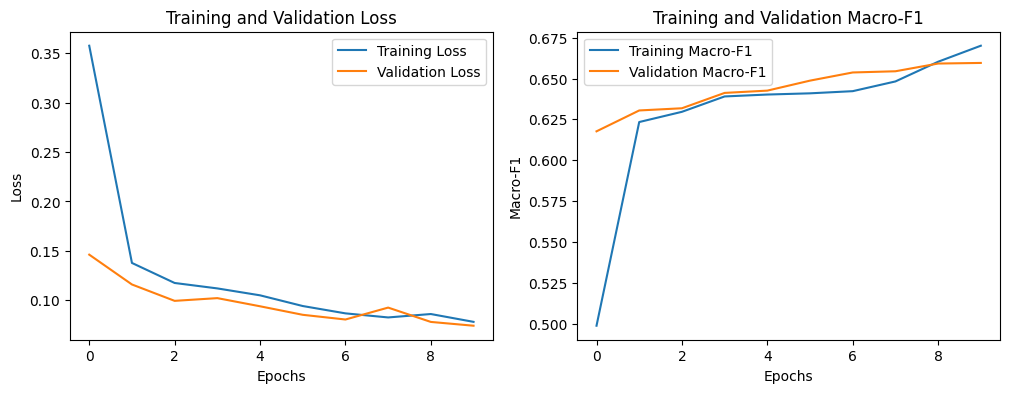

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Training Macro-F1')
plt.plot(val_f1s, label='Validation Macro-F1')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1')
plt.legend()
plt.title('Training and Validation Macro-F1')
plt.show()



# Save the model for future inference

In [ ]:
torch.save(model.state_dict(), 't2_model2_GloVe.pt')